##### Install PyQt5

This cell installs the pyqt5 library, which is required for enabling the Qt backend in matplotlib. It ensures interactive EEG visualizations can be displayed in separate windows.

In [1]:
%pip install pyqt5

Note: you may need to restart the kernel to use updated packages.


Matplotlib Backend Setting

This cell sets the matplotlib backend to qt, allowing plots to open in a separate interactive window. It enables flexible exploration of EEG plots such as signals, spectrograms, and topomaps, which is useful for detailed analysis beyond static inline figures.

In [2]:
%matplotlib qt

Import Libraries

The libraries imported here enable EEG data analysis and visualization. mne handles EEG data loading, filtering, and epoching; numpy provides efficient numerical computations; and matplotlib.pyplot is used to plot EEG signals and experimental results.

In [ ]:
import mne 
import numpy as np
import matplotlib.pyplot as plt

##### Subject Data Initialization

In this step, the training file for a chosen subject is loaded from the BCI Competition IV-2a dataset using mne.io.read_raw_gdf. Preloading ensures the full EEG recording is accessible in memory for subsequent filtering and epoching. The dataset information is then displayed with raw.info, which provides details such as the number of channels, sampling rate, filter settings, and subject metadata. This serves as a quick diagnostic check before preprocessing and analysis.

In [4]:
# Path to subject 1 training file
raw = mne.io.read_raw_gdf('BCICIV_2a_gdf/A02T.gdf', preload=True)

# See dataset info
print(raw.info)

Extracting EDF parameters from c:\Users\hamih\OneDrive\Desktop\personal projects\BCI\BCICIV_2a_gdf\A02T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


c:\Users\hamih\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Reading 0 ... 677168  =      0.000 ...  2708.672 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: EEG-Fz, EEG-0, EEG-1, EEG-2, EEG-3, EEG-4, EEG-5, EEG-C3, EEG-6, ...
 chs: 25 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 2004-11-15 12:00:00 UTC
 nchan: 25
 projs: []
 sfreq: 250.0 Hz
 subject_info: <subject_info | his_id: A02, sex: 0, last_name: X, birthday: 1980-11-15>
>


##### Load EEG Recording into Memory

Using raw.load_data(), the full EEG recording is loaded into memory, ensuring that all signal values are directly accessible for subsequent preprocessing. The dataset summary shows key details such as subject identifier, acquisition duration, sampling frequency, total time points, number of EEG channels, and applied filters. Having the complete data in memory is essential for efficient filtering, epoching, and feature extraction.

In [5]:
raw.load_data()

<RawGDF | A02T.gdf, 25 x 677169 (2708.7 s), ~129.2 MiB, data loaded>

##### Channel Inspection

The command raw.info['ch_names'] lists all available channel names in the EEG recording. This dataset contains standard EEG electrodes (e.g., Fz, Cz, C3, C4, etc.) along with additional channels. Notably, the last three channels are EOG-left, EOG-central, and EOG-right, which record eye movements. These are often removed during preprocessing to avoid contamination of motor imagery EEG signals by ocular artifacts. Inspecting channel names at this stage ensures correct handling of EEG and non-EEG channels in later steps.

In [6]:
raw.info['ch_names']

['EEG-Fz',
 'EEG-0',
 'EEG-1',
 'EEG-2',
 'EEG-3',
 'EEG-4',
 'EEG-5',
 'EEG-C3',
 'EEG-6',
 'EEG-Cz',
 'EEG-7',
 'EEG-C4',
 'EEG-8',
 'EEG-9',
 'EEG-10',
 'EEG-11',
 'EEG-12',
 'EEG-13',
 'EEG-14',
 'EEG-Pz',
 'EEG-15',
 'EEG-16',
 'EOG-left',
 'EOG-central',
 'EOG-right']

##### Raw Signal Visualization

The command raw.plot() generates a visualization of the continuous EEG signals recorded from all channels. Each trace corresponds to the voltage fluctuations of an electrode over time, allowing inspection of brain activity patterns as well as potential noise or artifacts. This diagnostic step is valuable before preprocessing, as it helps confirm proper data loading, highlights eye movement or muscle artifacts, and provides an overall view of the signal quality in the motor imagery dataset.

Using matplotlib as 2D backend.


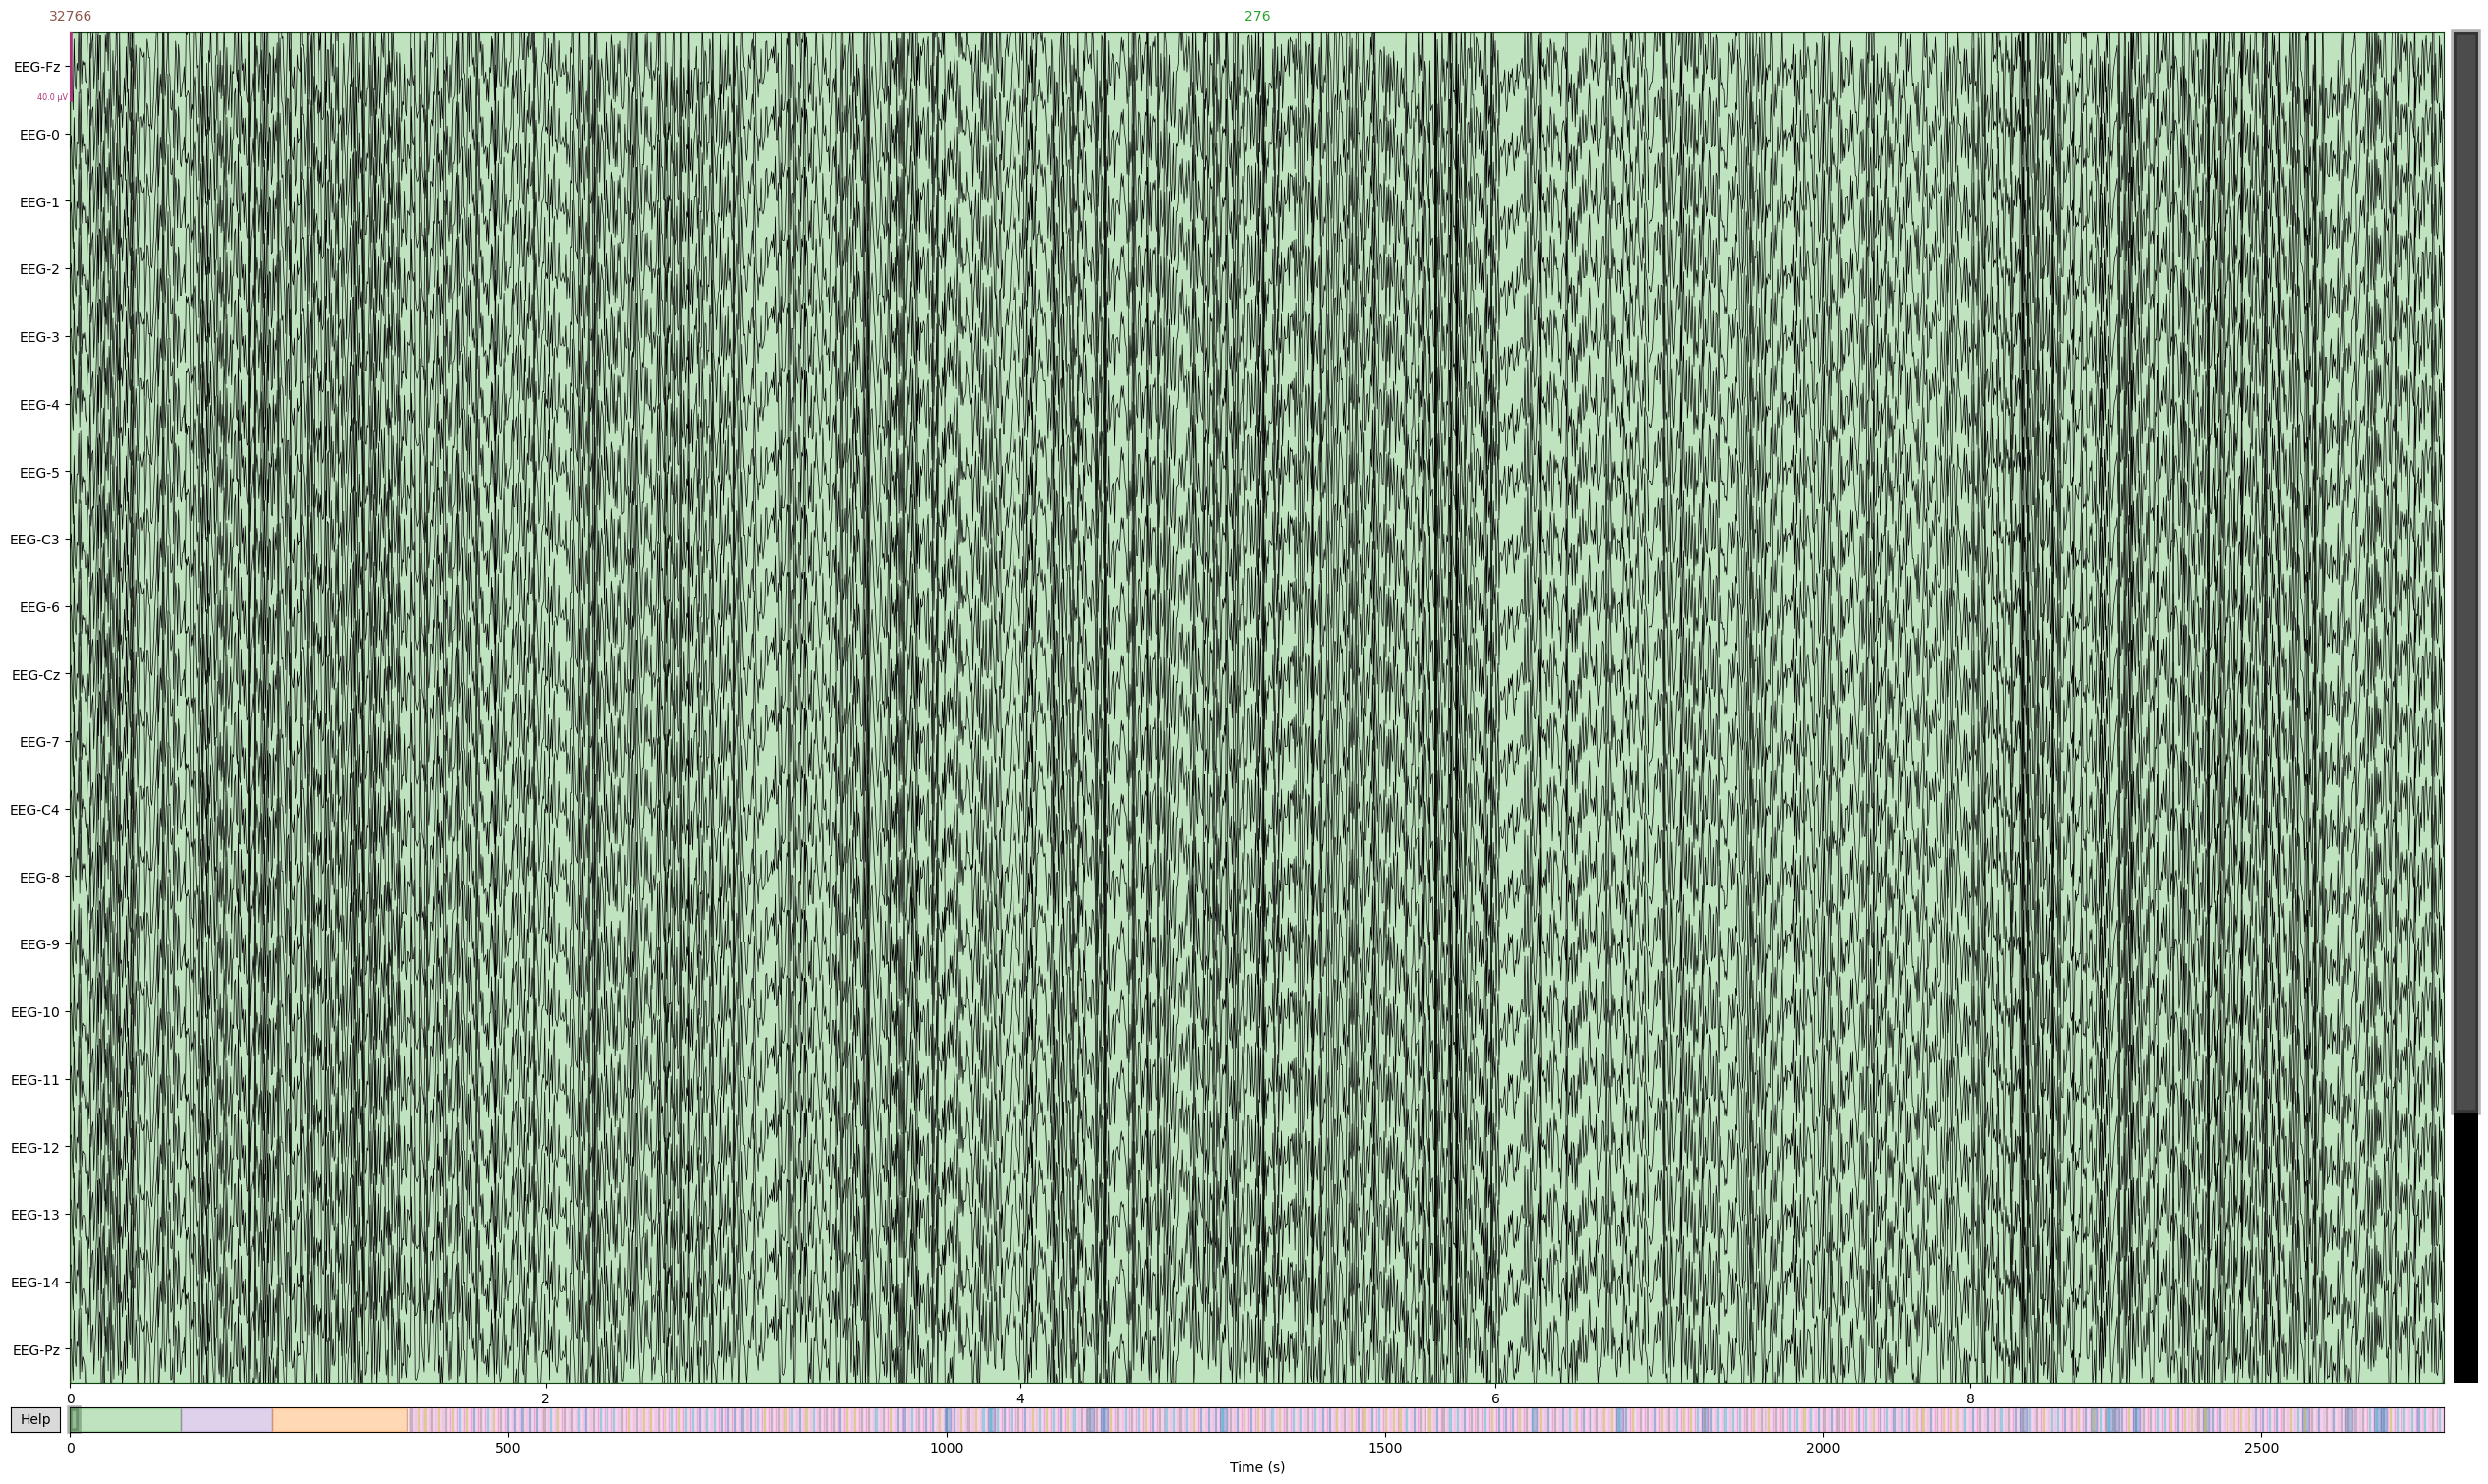

In [7]:
raw.plot()   # plot raw signals

##### Band-Pass Filtering

The EEG signals are filtered between 8–30 Hz using a finite impulse response (FIR) filter. This frequency range is selected because it encompasses the mu (8–12 Hz) and beta (13–30 Hz) rhythms, which are the most informative bands for motor imagery tasks. These rhythms are strongly modulated during imagined movements of the hands, feet, and tongue, making them crucial for brain–computer interface (BCI) decoding. Filtering out frequencies below 8 Hz removes slow drifts and artifacts (e.g., movement or electrode shifts), while excluding frequencies above 30 Hz eliminates muscle activity and high-frequency noise, focusing the analysis on neural oscillations most relevant to motor imagery classification.

In [8]:
# Band-pass filter
raw.filter(8., 30., method="fir")

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



<RawGDF | A02T.gdf, 25 x 677169 (2708.7 s), ~129.2 MiB, data loaded>

##### Event Extraction

The annotations in the raw EEG recording are converted into numerical event markers using mne.events_from_annotations. These events correspond to different motor imagery tasks (e.g., left hand, right hand, feet, tongue) and will later guide the epoching process. This step ensures that each trial can be segmented and labeled appropriately for classification.

In [9]:
# Extract events from annotations
events, _ = mne.events_from_annotations(raw)

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


##### Channel Selection and EOG Removal

EOG (electrooculography) channels ("EOG-left", "EOG-central", and "EOG-right") are marked as bad and excluded, since they capture eye movements that introduce noise into EEG-based motor imagery analysis. Only EEG channels are retained using mne.pick_types. The resulting picks array specifies the indices of valid EEG channels, ensuring that subsequent processing focuses solely on brain activity relevant to motor imagery classification.

In [10]:
# Remove the EOG channels and pick only eeg channels
raw.info['bads'] += ["EOG-left", "EOG-central", "EOG-right"]
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False, exclude='bads')

In [11]:
picks

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [12]:
print(raw.ch_names)

['EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5', 'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9', 'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15', 'EEG-16', 'EOG-left', 'EOG-central', 'EOG-right']


##### Channel Renaming

The dataset originally labels EEG channels with generic or numerical identifiers (e.g., "EEG-0", "EEG-1", "EEG-2"). To improve readability and align with standard EEG conventions, a mapping dictionary is defined to rename these channels to their corresponding standard positions on the 10–20 system (e.g., "EEG-0" → "FC3", "EEG-C3" → "C3", "EEG-Pz" → "Pz"). This step ensures consistency with commonly used electrode nomenclature, making the data easier to interpret and compatible with established EEG analysis pipelines.

In [13]:
mapping = {
    'EEG-Fz': 'Fz',
    'EEG-0': 'FC3',
    'EEG-1': 'FC1',
    'EEG-2': 'FCz',
    'EEG-3': 'FC2',
    'EEG-4': 'FC4',
    'EEG-5': 'C5',
    'EEG-C3': 'C3',
    'EEG-6': 'C1',
    'EEG-Cz': 'Cz',
    'EEG-7': 'C2',
    'EEG-C4': 'C4',
    'EEG-8': 'C6',
    'EEG-9': 'CP3',
    'EEG-10': 'CP1',
    'EEG-11': 'CPz',
    'EEG-12': 'CP2',
    'EEG-13': 'CP4',
    'EEG-14': 'P1',
    'EEG-Pz': 'Pz',
    'EEG-15': 'P2',
    'EEG-16': 'POz'
}


##### Channel Cleanup and Montage Setup

In this step, the EOG channels (EOG-left, EOG-central, EOG-right) are manually removed from the dataset using raw.drop_channels(). These electrodes record eye movements and blinks, which act as noise for motor imagery classification tasks. While marking them as “bad channels” (raw.info['bads']) is a common strategy to exclude noisy EEG electrodes without losing their metadata, the EOG signals are not EEG at all and are unnecessary for this study.

They were initially flagged as “bad” to keep track of them, but for applying the standard 10–20 montage, they needed to be removed entirely. This is because MNE’s montage system still “sees” flagged channels and attempts to include them, leading to mismatches when aligning electrodes to canonical positions. By dropping them completely, the dataset contains only the EEG channels of interest, ensuring both computational efficiency and compatibility with the standard electrode layout.

After removal, the EEG channel names are mapped to the 10–20 system, and the standard_1020 montage is applied. The electrode positions are then visualized to confirm correct spatial arrangement, ensuring proper alignment with neurophysiological conventions for motor imagery analysis.

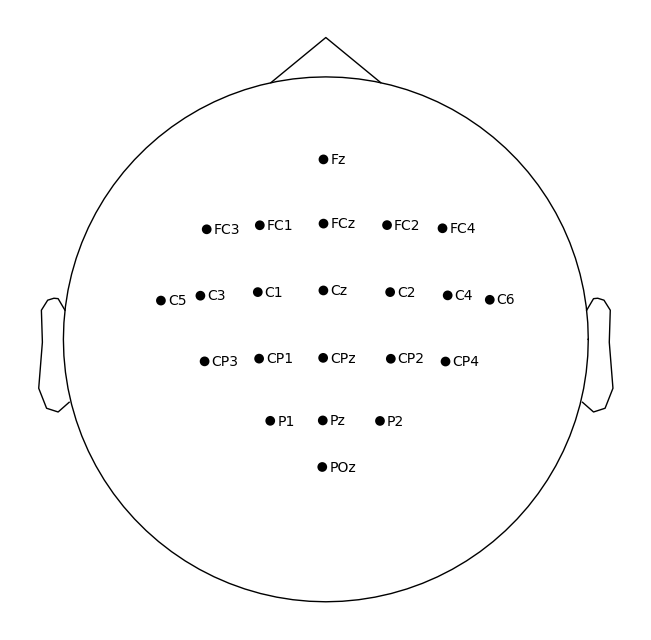

In [14]:
# Drop EOG channels 
raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

# Rename channels using mapping
raw.rename_channels(mapping)

# Apply standard 10–20 montage
raw.set_montage('standard_1020')

# Verify electrode positions
raw.plot_sensors(kind='topomap', show_names=True)


##### Event Inspection and Annotation Mapping

This step verifies the events embedded in the raw EEG recording. First, np.unique(events[:, 2]) is used to list all unique event codes detected in the dataset, confirming the range of stimulus and task markers present.

Next, mne.events_from_annotations(raw) extracts the full mapping between annotation labels and their corresponding event IDs. This provides a dictionary that links coded numbers (e.g., 7, 8, 9, 10) to meaningful experimental conditions, such as motor imagery of the left hand, right hand, feet, and tongue.

This process ensures that only the relevant task events are identified and prepares the dataset for epoching into class-specific trials.

In [15]:
print(np.unique(events[:, 2]))


[ 1  2  3  4  5  6  7  8  9 10]


In [16]:
events, event_id = mne.events_from_annotations(raw)
print(event_id)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
{'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}


##### Event ID Dictionary

In this step, a custom dictionary event_id is defined to map motor imagery conditions to their corresponding event codes. The BCI Competition IV-2a dataset encodes tasks with numeric labels (7 = left hand, 8 = right hand, 9 = feet, 10 = tongue). Assigning them descriptive keys ('left_hand', 'right_hand', 'feet', 'tongue') makes the code more readable and ensures that later steps, such as epoching and classification, use meaningful task names instead of raw integers.

In [17]:
event_id = {
    'left_hand': 7,
    'right_hand': 8,
    'feet': 9,
    'tongue': 10
}


##### Epoch Extraction

In this step, EEG data is segmented into epochs using mne.Epochs(). Each epoch corresponds to a motor imagery trial defined by the event_id dictionary. The time window is set from 0.5 to 3.5 seconds (tmin=0.5, tmax=3.5) relative to the cue onset.

This time frame is chosen deliberately:

• The first 0.5 seconds after the cue are excluded to avoid contamination from visual evoked potentials and reaction artifacts.

• The window from 0.5 to 3.5 seconds captures the core motor imagery activity, which is typically sustained over several seconds.

• Using 3 seconds of clean data balances having enough temporal information for classification while minimizing noise accumulation.

The picks argument ensures that only EEG channels (after EOG removal) are included.

In [18]:
epochs = mne.Epochs(raw, events, event_id=event_id,
                    tmin=0.5, tmax=3.5,
                    picks=picks, baseline=None, preload=True)


Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 751 original time points ...
0 bad epochs dropped


Trial Count per Class

In this step, the number of extracted epochs for each motor imagery class is calculated using the event_id dictionary. The output confirms that:

Left hand: 72 trials

Right hand: 72 trials

Feet: 72 trials

Tongue: 72 trials

This perfectly balanced trial distribution is expected for the BCI Competition IV-2a dataset, where each subject performs 288 trials (72 per class).

In [19]:
for key in event_id:
    print(f"{key}: {len(epochs[key])} trials")


left_hand: 72 trials
right_hand: 72 trials
feet: 72 trials
tongue: 72 trials


Class Distribution Visualization

A bar plot is generated to visualize the number of trials across the four classes. Since each class has exactly 72 trials, the bars are equal in height, showing a balanced dataset.

In [20]:
# Bar plot for class distribution
counts = [len(epochs[key]) for key in event_id]
plt.bar(event_id.keys(), counts)
plt.title("Trials per Class")
plt.ylabel("Count")
plt.show()

##### Power Spectral Density (PSD) Analysis

In this step, the power spectral density (PSD) of the epoched EEG signals was computed and visualized up to 40 Hz. The PSD shows how signal power is distributed across different frequencies and is a standard way to evaluate the quality and characteristics of EEG data after preprocessing. Averaging across epochs provides a stable estimate of the frequency content, highlighting the dominant rhythms present in the dataset.

The chosen range of 0–40 Hz ensures that the analysis captures the most relevant EEG frequency bands. In particular, the mu rhythm (8–12 Hz) and beta rhythm (13–30 Hz) are key markers of motor imagery, as they show event-related desynchronization and synchronization linked to motor planning and imagination. Including frequencies up to 40 Hz allows inspection of the higher beta and low gamma ranges while still avoiding noise-dominated higher frequencies that provide little information for motor imagery tasks.

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


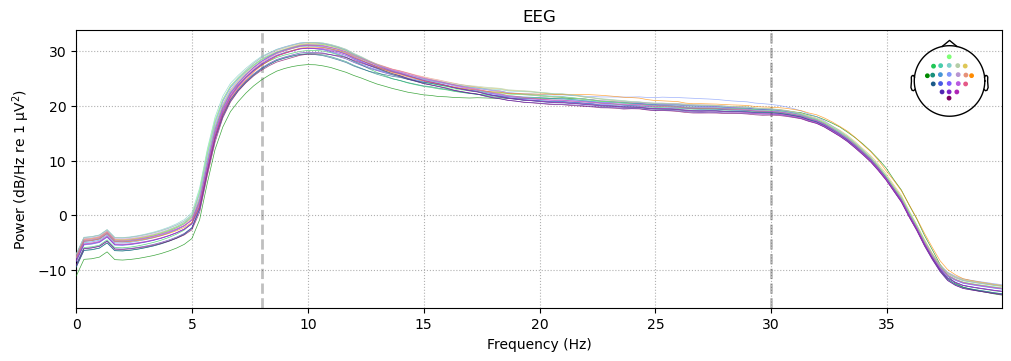

In [21]:
# PSD plot (0–40 Hz)
epochs.plot_psd(fmax=40)

##### Topographic Map of PSD

A topographic map of PSD is created to visualize the spatial distribution of spectral power across Delta, Theta, Alpha, Beta, and Gamma bands. This highlights how rhythms are localized on the scalp, with alpha and beta activity over central areas being especially relevant for motor imagery analysis.

NOTE: plot_psd_topomap() is a legacy function. New code should use .compute_psd().plot_topomap().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs before plotting...


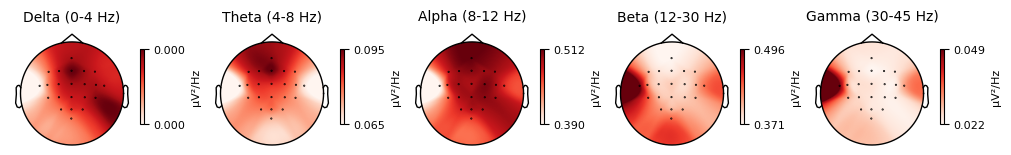

In [22]:
# Topographic map of PSD
epochs.plot_psd_topomap(ch_type='eeg', normalize=True)

##### Evoked Responses for Motor Imagery

This step visualizes the averaged EEG signals for left-hand and right-hand motor imagery (MI) trials. Each plot shows event-related responses across 22 EEG channels, averaged over 72 trials per condition. The traces reveal stable oscillatory activity in the 0.5–3.5 s window following stimulus onset, characteristic of motor-related desynchronization.

For left-hand MI, the responses show moderate rhythmic fluctuations across channels, with some stronger activity emerging around 1–1.5 s. For right-hand MI, the oscillatory activity is slightly stronger after ~1.5 s, with amplitudes reaching closer to ±3 µV, suggesting clearer synchronization and desynchronization patterns compared to the left-hand condition.

These averaged plots demonstrate consistent and distinguishable neural responses for both tasks, confirming that the preprocessing pipeline preserved motor imagery signatures and providing a reliable foundation for subsequent feature extraction and classification.

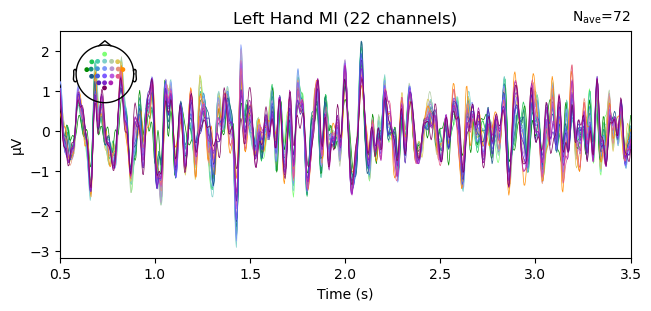

In [23]:
# Evoked responses (averages)
epochs['left_hand'].average().plot(spatial_colors=True, titles="Left Hand MI")

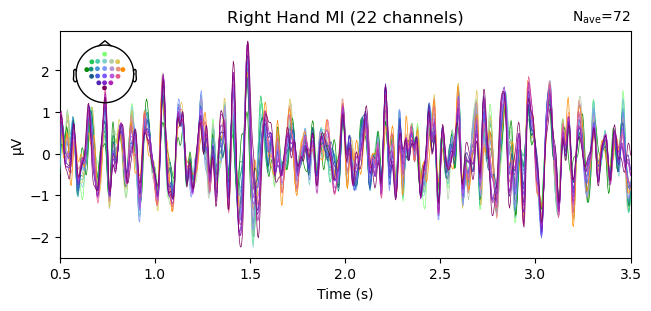

In [24]:
epochs['right_hand'].average().plot(spatial_colors=True, titles="Right Hand MI")

##### Power Spectral Density for Left and Right Hand MI

These plots show the power spectral density (PSD) for the left-hand and right-hand motor imagery (MI) conditions, separately. Each line represents the spectral profile of one EEG channel, averaged across all trials in that condition. Both conditions display the expected peaks within the mu (8–12 Hz) and beta (13–30 Hz) bands, which are most relevant for motor activity.

Compared to the earlier PSD plots (which pooled all motor imagery conditions), these condition-specific plots highlight subtle differences between left- and right-hand imagery. For example, slight variations in mu and beta power across channels can be observed, reflecting contralateral sensorimotor activation patterns. Analyzing PSDs per condition provides more precise insights into how imagined movements modulate spectral features, which is crucial for classification in brain–computer interface (BCI) tasks.

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


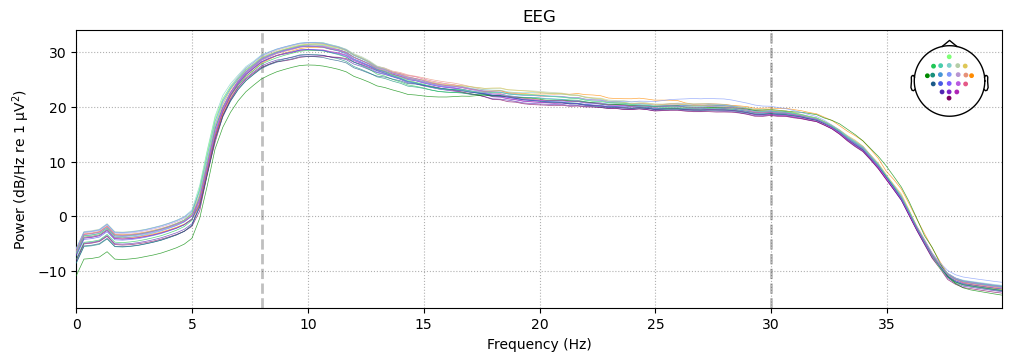

In [25]:
epochs['left_hand'].plot_psd(fmax=40)


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


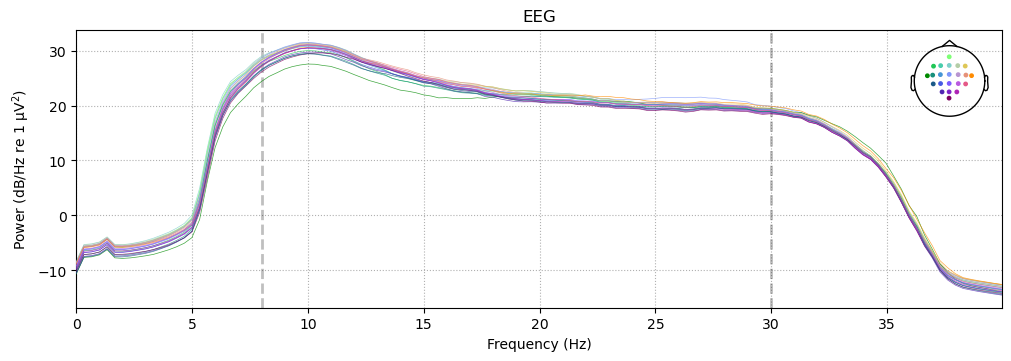

In [26]:
epochs['right_hand'].plot_psd(fmax=40)

##### Time-Resolved Topographies for Motor Imagery

These plots show the scalp voltage distributions for left- and right-hand motor imagery (MI) at 1.0 s, 2.0 s, and 3.0 s. For the left-hand MI, activity peaks around 2.0 s over the right central and centro-parietal regions (C4/CP4 area), consistent with contralateral motor cortex engagement. The effect weakens by 3.0 s but remains lateralized.

For the right-hand MI, the strongest modulation also appears around 2.0 s, localized over the left central region (C3/CP3 area). However, the response is weaker overall, with a smaller amplitude range (~±0.6 µV compared to ~±1.2 µV for the left-hand condition).

These maps confirm contralateral sensorimotor involvement during MI while also showing subject-specific asymmetry, with stronger responses for left-hand imagery.

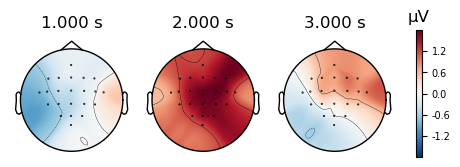

In [27]:
epochs['left_hand'].average().plot_topomap(times=[1.0, 2.0, 3.0], ch_type='eeg')

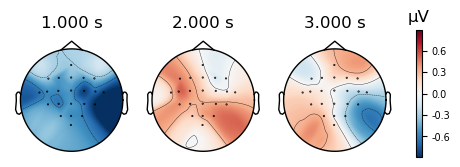

In [28]:
epochs['right_hand'].average().plot_topomap(times=[1.0, 2.0, 3.0], ch_type='eeg')

##### Time-Frequency Representations for Motor Imagery

These plots use the multitaper method to compute time-frequency representations (TFRs) for left-hand and right-hand motor imagery (MI). Each small square corresponds to one EEG channel, showing how power evolves across time (x-axis) and frequency (y-axis). Warmer colors indicate higher power, while cooler colors reflect power reductions relative to baseline.

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
No baseline correction applied


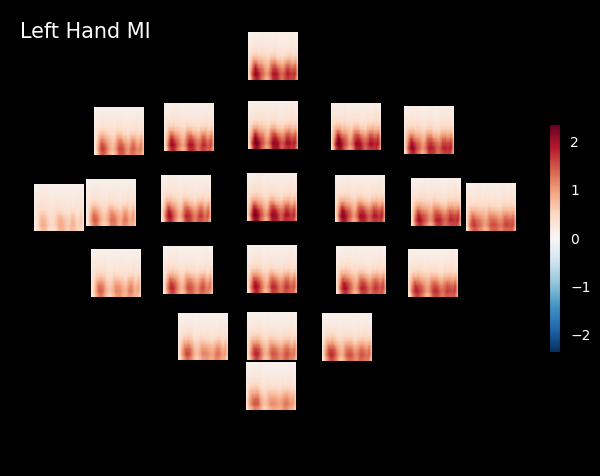

In [29]:
power = mne.time_frequency.tfr_multitaper(
    epochs['left_hand'], freqs=np.arange(8, 31, 2),
    n_cycles=4, return_itc=False)
power.plot_topo(mode='logratio', title='Left Hand MI')

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
No baseline correction applied


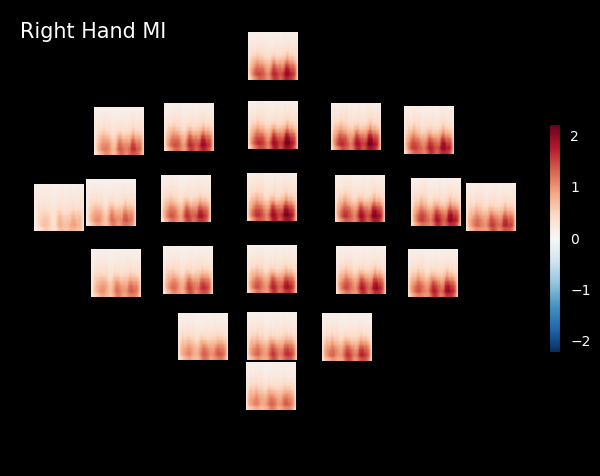

In [30]:
power = mne.time_frequency.tfr_multitaper(
    epochs['right_hand'], freqs=np.arange(8, 31, 2),
    n_cycles=4, return_itc=False)
power.plot_topo(mode='logratio', title='Right Hand MI')

##### Time-Frequency Analysis at C3 and C4

This step visualizes time–frequency representations (TFRs) specifically for the C3 and C4 electrodes, which lie directly over the left and right sensorimotor cortices. These sites are the most informative for hand motor imagery because they capture contralateral desynchronization patterns.

For C3, stronger desynchronization is expected during right-hand imagery, since the left motor cortex controls the right hand. For C4, the opposite holds: desynchronization is more pronounced during left-hand imagery, reflecting contralateral control of the left hand.

Compared to the previous whole-scalp TFRs, this channel-focused analysis highlights the most relevant features for classification in motor imagery BCIs, isolating the activity at electrodes where mu (8–12 Hz) and beta (13–30 Hz) rhythms are most affected.

In [31]:
power.plot([epochs.info['ch_names'].index('C3')])

No baseline correction applied


[<Figure size 640x480 with 2 Axes>]

In [32]:
power.plot([epochs.info['ch_names'].index('C4')])

No baseline correction applied


[<Figure size 640x480 with 2 Axes>]